<header style="padding:1px;background:#f9f9f9;border-top:3px solid #00b2b1"><img id="Teradata-logo" src="https://www.teradata.com/Teradata/Images/Rebrand/Teradata_logo-two_color.png" alt="Teradata" width="220" align="right" />

<b style = 'font-size:28px;font-family:Arial;color:#E37C4D'>GLM Fraud Detection with Python and Vantage BYOM</b>
</header>

### Disclaimer
TERADATA DISCLAIMS ALL WARRANTIES RELATING TO THE CODE, EXPRESS OR IMPLIED, INCLUDING, BUT NOT LIMITED TO, ANY WARRANTIES AGAINST INFRINGEMENT OF THIRD-PARTY RIGHTS, MERCHANTABILITY AND FITNESS FOR A PARTICULAR PURPOSE.

TERADATA SHALL NOT BE RESPONSIBLE OR LIABLE WITH RESPECT TO ANY SUBJECT MATTER OF THE CODE UNDER ANY CONTRACT, NEGLIGENCE, STRICT LIABILITY OR OTHER THEORY 
    (A) FOR LOSS OR INACCURACY OF DATA OR COST OF PROCUREMENT OF SUBSTITUTE GOODS, SERVICES OR TECHNOLOGY, OR 
    (B) FOR ANY INDIRECT, INCIDENTAL OR CONSEQUENTIAL DAMAGES INCLUDING, BUT NOT LIMITED TO LOSS OF REVENUES AND LOSS OF PROFITS. TERADATA SHALL NOT BE RESPONSIBLE FOR ANY MATTER BEYOND ITS REASONABLE CONTROL.

Notwithstanding anything to the contrary: 
    (a) Teradata will have no obligation of any kind with respect to any Code-related comments, suggestions, design changes or improvements that you elect to provide to Teradata in either verbal or written form (collectively, “Feedback”), and 
    (b) Teradata and its affiliates are hereby free to use any ideas, concepts, know-how or techniques, in whole or in part, contained in Feedback: 
        (i) for any purpose whatsoever, including developing, manufacturing, and/or marketing products and/or services incorporating Feedback in whole or in part, and 
        (ii) without any restrictions or limitations, including requiring the payment of any license fees, royalties, or other consideration. 

## Introduction
##### Imagine yourself at the checkout counter of a grocery store on a Friday evening. You give your credit card to the cashier and you hear the not so expected line "your card has been declined". You are wondering how? You have enough funds in your bank account. You credit card is blocked because someone tried to make fraudulent purchase using your card. Scenario like these have become so common in today's world. Financial institutions are working hard to find solutions to either stop these scams or detect and prevent minimize the risk and loss of business.  

##### This notebook showcases a workflow that uses teradataml to load the data in Vantage, "Bring Your Own Model" functions to load the model in Vantage and score the model.

Workflow steps:
1. Import the required teradataml modules.
2. Connect to a Vantage system.
3. Data Loading.
4. Data Analysis e.g. use of various dataframe functions to get details about the data like shape, fraudulent transaction count, non-fraudulent transaction counts etc.
5. Data preparation - Split the data into train and test sets.
6. Model the data outside Vantage using scikit-learn's PMMLPipeline.
7. Bring the Model generated in previous step to a Vantage table using teradataml function.
8. Score the model in Vantage.
9. Visualize the ROC curve using teradataml Plot().
10. Cleanup.

<hr>
<b style = 'font-size:28px;font-family:Arial;color:#E37C4D'>1. Import the required modules.</b>

In [1]:
# Import.
import os
import getpass

from collections import OrderedDict

from teradataml.context.context import *
from teradataml.dataframe.copy_to import copy_to_sql
from teradataml.dataframe.dataframe import DataFrame
from teradataml.dataframe.fastload import fastload
from teradataml import read_csv
from teradataml.options.configure import configure
from teradataml.analytics.byom.PMMLPredict import PMMLPredict
from teradataml import save_byom, db_drop_table, delete_byom, retrieve_byom

from teradatasqlalchemy import (BIGINT, FLOAT)
from sklearn.linear_model import LogisticRegression
from sklearn2pmml.pipeline import PMMLPipeline
from sklearn2pmml import sklearn2pmml
warnings.filterwarnings("ignore")


<hr>
<b style = 'font-size:28px;font-family:Arial;color:#E37C4D'>2. Connect to Vantage</b>
<p style = 'font-size:16px;font-family:Arial'>You will be prompted to enter the host name, username and password.</p>

In [2]:
con = create_context(host=getpass.getpass("Hostname: "), 
                     username=getpass.getpass("Username: "),
                     password=getpass.getpass("Password: "))

Hostname:  ········
Username:  ········
Password:  ········


<hr>
<b style = 'font-size:28px;font-family:Arial;color:#E37C4D'>3. Data Loading</b>

##### Data Source: https://www.kaggle.com/datasets/mlg-ulb/creditcardfraud
##### The dataset contains transactions made by credit cards in September 2013 by European cardholders.
##### This dataset presents transactions that occurred in two days, where we have 492 frauds out of 284,807 transactions. Features V1, V2, … V28 are the principal components obtained with PCA.

In [3]:
# The read_csv() API loads data from CSV file into Teradata Vantage.
types = OrderedDict(Time=FLOAT, V1=FLOAT, V2=FLOAT, V3=FLOAT, V4=FLOAT, V5=FLOAT, V6=FLOAT, V7=FLOAT, V8=FLOAT, 
                    V9=FLOAT, V10=FLOAT, V11=FLOAT, V12=FLOAT, V13=FLOAT, V14=FLOAT, V15=FLOAT, V16=FLOAT, V17=FLOAT, 
                    V18=FLOAT, V19=FLOAT, V20=FLOAT, V21=FLOAT, V22=FLOAT, V23=FLOAT, V24=FLOAT, V25=FLOAT, V26=FLOAT, 
                    V27=FLOAT, V28=FLOAT, Amount=FLOAT, Class=BIGINT)
df_fraud = read_csv(filepath = getpass.getpass("filepath: "), table_name = 'glm_fraud_data', types=types)

filepath:  ········


<hr>
<b style = 'font-size:28px;font-family:Arial;color:#E37C4D'>4. Data Analysis & Cleanup</b>

In [4]:
# Shape of the dataframe.
df_fraud.shape

(284807, 31)

In [5]:
# Print the dataframe.
df_fraud

Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
2.0,-0.425965884412454,0.960523044882985,1.14110934232219,-0.168252079760302,0.42098688077219,-0.0297275516639742,0.476200948720027,0.260314333074874,-0.56867137571251,-0.371407196834471,1.34126198001957,0.359893837038039,-0.358090652573631,-0.137133700217612,0.517616806555742,0.401725895589603,-0.0581328233640131,0.0686531494425432,-0.0331937877876282,0.0849676720682049,-0.208253514656728,-0.559824796253248,-0.0263976679795373,-0.371426583174346,-0.232793816737034,0.105914779097957,0.253844224739337,0.0810802569229443,3.67,0
9.0,-0.33826175242575,1.11959337641566,1.04436655157316,-0.222187276738296,0.49936080649727,-0.24676110061991,0.651583206489972,0.0695385865186387,-0.736727316364109,-0.366845639206541,1.01761446783262,0.836389570307029,1.00684351373408,-0.443522816876142,0.150219101422635,0.739452777052119,-0.540979921943059,0.47667726004282,0.451772964394125,0.203711454727929,-0.246913936910008,-0.633752642406113,-0.12079408408185,-0.385049925313426,-0.0697330460416923,0.0941988339514961,0.246219304619926,0.0830756493473326,3.68,0
10.0,0.38497821518095,0.616109459176472,-0.874299702595052,-0.0940186259679115,2.92458437838817,3.31702716826156,0.470454671805879,0.53824722837695,-0.558894612428441,0.30975539423728,-0.259115563735702,-0.326143233995877,-0.0900467227020648,0.362832368569793,0.928903660629178,-0.129486811402759,-0.809978925963589,0.359985390219981,0.70766382644648,0.12599157561542,0.049923685888971,0.238421512225103,0.00912986861262866,0.996710209581086,-0.767314827174801,-0.492208295340017,0.042472441919027,-0.0543373883732122,9.99,0
11.0,1.0693735878819,0.287722129331455,0.828612726634281,2.71252042961718,-0.178398016248009,0.337543730282968,-0.0967168617395962,0.115981735546597,-0.221082566236194,0.460230444301678,-0.773656930526689,0.32338724546722,-0.0110758870883779,-0.178485175177916,-0.65556427824926,-0.19992517131173,0.1240054151819,-0.980496201537345,-0.982916082135047,-0.153197231044512,-0.0368755317335273,0.0744124028162195,-0.0714074332998586,0.104743752596029,0.548264725394119,0.104094153162781,0.0214910583643189,0.021293311477486,27.5,0
13.0,-0.436905071360625,0.918966212909322,0.92459077438817,-0.727219053596792,0.915678718106307,-0.127867352079254,0.707641607333935,0.0879623554672504,-0.66527135413364,-0.737979823596458,0.32409781346169,0.277192107214981,0.252624256310781,-0.291896460370468,-0.184520169327133,1.14317370716197,-0.92870926272403,0.680469592634687,0.0254364616880793,-0.0470212823165035,-0.194795823794671,-0.672637997017793,-0.156857514491897,-0.888386320943716,-0.342413218776576,-0.049026728633951,0.0796923991551505,0.131023789452311,0.89,0
15.0,1.4929359769862,-1.02934573189487,0.45479473374366,-1.43802587991702,-1.55543410136344,-0.720961147043557,-1.08066413038614,-0.0531271179483221,-1.9786815953872,1.63807603690446,1.07754241162743,-0.63204651464934,-0.41695716661602,0.0520105153724404,-0.0429789228232019,-0.166432496451972,0.304241418614353,0.554432499062278,0.0542295152184719,-0.387910172646258,-0.177649846438814,-0.175073809074822,0.0400022190621329,0.295813862676508,0.33293059939425,-0.220384850672322,0.0222984359135846,0.00760225559997897,5.0,0
12.0,-0.752417042956605,0.345485415344747,2.05732291276727,-1.46864329840046,-1.1583936804082,-0.0778498291166733,-0.608581418236123,0.00360348436201849,-0.436166983515744,0.747730827192802,-0.793980602837221,-0.770406728847129,1.04762699748088,-1.06660368148653,1.10695345662141,1.66011355713381,-0.279265373246772,-0.419994141181313,0.432535348618175,0.263450864446125,0.499624954671111,1.35365048557231,-0.256573280448308,-0.0650837078816517,-0.0391243535426488,-0.0870864732146962,-0.180997500092721,0.129394059390202,15.99,0
7.0,-0.644269442348146,1.41796354547385,1.0743803763556,-0.492199018495015,0.948934094764157,0.428118462833089,1.12063135838353,-3.80786423873589,0.615374730667027,1.24937617815176,-0.61946

In [6]:
# Print a summary of the DataFrame.
df_fraud.info(null_counts=True)

<class 'teradataml.dataframe.dataframe.DataFrame'>
Data columns (total 31 columns):
Time      284807 non-null float
V1        284807 non-null float
V2        284807 non-null float
V3        284807 non-null float
V4        284807 non-null float
V5        284807 non-null float
V6        284807 non-null float
V7        284807 non-null float
V8        284807 non-null float
V9        284807 non-null float
V10       284807 non-null float
V11       284807 non-null float
V12       284807 non-null float
V13       284807 non-null float
V14       284807 non-null float
V15       284807 non-null float
V16       284807 non-null float
V17       284807 non-null float
V18       284807 non-null float
V19       284807 non-null float
V20       284807 non-null float
V21       284807 non-null float
V22       284807 non-null float
V23       284807 non-null float
V24       284807 non-null float
V25       284807 non-null float
V26       284807 non-null float
V27       284807 non-null float
V28       284807 non

#### Find the number of fraudulent transactions.

In [7]:
# Create a dataframe of fraudulent transactions.
fraud_df = df_fraud[df_fraud.Class == 1]

In [8]:
# Count of fraudulent transactions.
fraud_count = fraud_df.shape[0]
fraud_count

492

In [9]:
# Create a dataframe of non-fraudulent transactions.
non_fraud_df = df_fraud[df_fraud.Class == 0]

In [10]:
# Count of non-fraudulent transactions.
non_fraud_count = non_fraud_df.shape[0]
non_fraud_count

284315

#### Fraud and non-fraud cases statistics

In [11]:
fraud_amount_df = fraud_df.select(["Amount"])

In [12]:
# Generate regular aggregates.
fraud_amount_df.describe()

func,Amount
min,0
std,256.683
25%,1
50%,9.25
75%,105.89
max,2125.87
mean,122.211
count,492


In [13]:
non_fraud_amount_df = non_fraud_df.select(["Amount"])

In [14]:
# Generate regular aggregates.
non_fraud_amount_df.describe()

func,Amount
min,0
std,250.105
25%,5.65
50%,22
75%,77.05
max,25691.16
mean,88.291
count,284315


<hr>
<b style = 'font-size:28px;font-family:Arial;color:#E37C4D'>5. Data Preparation</b>

#### Split the data into test and train. 

In [15]:
# sample() function can be used to split the data. 
df_sample = df_fraud.sample(frac=[0.8, 0.2]).drop(columns=['Time'])

In [16]:
# Print the dataframe.
df_sample

V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class,sampleid
-1.15823309349523,0.877736754848451,1.548717846511,0.403033933955121,-0.407193377311653,0.0959214624684256,0.592940745385545,-0.270532677192282,0.817739308235294,0.753074431976354,-0.822842877946363,0.53819555014995,1.3458515932154,-1.11966983471731,0.175121130008994,-0.451449182813529,-0.237033239362776,-0.0381947870352842,0.803486924960175,0.408542360392758,-0.00943069713232919,0.79827849458971,-0.137458079619063,0.141266983824769,-0.206009587619756,0.502292224181569,0.219422229513348,0.215153147499206,69.99,0,1
-0.89428608220282,0.286157196276544,-0.113192212729871,-0.271526130088604,2.6695986595986,3.72181806112751,0.370145127676916,0.851084443200905,-0.392047586798604,-0.410430432848439,-0.705116586646536,-0.110452261733098,-0.286253632470583,0.0743553603016731,-0.328783050303565,-0.210077268148783,-0.499767968800267,0.118764861004217,0.57032816746536,0.0527356691149697,-0.0734251001059225,-0.268091632235551,-0.204232669947878,1.0115918018785,0.373204680146282,-0.384157307702294,0.0117473564581996,0.14240432992147,93.2,0,1
1.44904378114715,-1.17633882535966,0.913859832832795,-1.37566665499943,-1.97138316545323,-0.62915213889734,-1.4232356010359,0.0484558879088564,-1.72040839292037,1.62665905834133,1.1996439495421,-0.671439778462005,-0.513947152539479,-0.0950450453999549,0.230930409124119,0.0319674667862076,0.253414715863197,0.854343814324194,-0.221365413645481,-0.387226474431156,-0.00930189652490052,0.313894410791098,0.0277401580170247,0.500512287104917,0.25136735874921,-0.129477953726618,0.0428498709381461,0.0162532619375515,7.8,0,1
1.19185711131486,0.26615071205963,0.16648011335321,0.448154078460911,0.0600176492822243,-0.0823608088155687,-0.0788029833323113,0.0851016549148104,-0.255425128109186,-0.166974414004614,1.61272666105479,1.06523531137287,0.48909501589608,-0.143772296441519,0.635558093258208,0.463917041022171,-0.114804663102346,-0.183361270123994,-0.145783041325259,-0.0690831352230203,-0.225775248033138,-0.638671952771851,0.101288021253234,-0.339846475529127,0.167170404418143,0.125894532368176,-0.00898309914322813,0.0147241691924927,2.69,0,2
-0.425965884412454,0.960523044882985,1.14110934232219,-0.168252079760302,0.42098688077219,-0.0297275516639742,0.476200948720027,0.260314333074874,-0.56867137571251,-0.371407196834471,1.34126198001957,0.359893837038039,-0.358090652573631,-0.137133700217612,0.517616806555742,0.401725895589603,-0.0581328233640131,0.0686531494425432,-0.0331937877876282,0.0849676720682049,-0.208253514656728,-0.559824796253248,-0.0263976679795373,-0.371426583174346,-0.232793816737034,0.105914779097957,0.253844224739337,0.0810802569229443,3.67,0,1
-0.644269442348146,1.41796354547385,1.0743803763556,-0.492199018495015,0.948934094764157,0.428118462833089,1.12063135838353,-3.80786423873589,0.615374730667027,1.24937617815176,-0.619467796121913,0.291474353088705,1.75796421396042,-1.32386521970526,0.686132504394383,-0.0761269994382006,-1.2221273453247,-0.358221569869078,0.324504731321494,-0.156741852488285,1.94346533978412,-1.01545470979971,0.057503529867291,-0.649709005559993,-0.415266566234811,-0.0516342969262494,-1.20692108094258,-1.08533918832377,40.8,0,1
-0.33826175242575,1.11959337641566,1.04436655157316,-0.222187276738296,0.49936080649727,-0.24676110061991,0.651583206489972,0.0695385865186387,-0.736727316364109,-0.366845639206541,1.01761446783262,0.836389570307029,1.00684351373408,-0.443522816876142,0.150219101422635,0.739452777052119,-0.540979921943059,0.47667726004282,0.451772964394125,0.203711454727929,-0.246913936910008,-0.633752642406113,-0.12079408408185,-0.385049925313426,-0.0697330460416923,0.0941988339514961,0.246219304619926,0.0830756493473326,3.68,0,1
0.38497821518095,0.616109459176472,-0.874299702595052,-0.0940186259679115,2.92458437838817,3.31702716826156,0.470454671805879,0.53824722837695,-0.558894612428441,0.30975539423728,-0.259115563735702,-0.326143233995877

In [17]:
# Create train dataset from sample 1 by filtering on "sampleid" and drop "sampleid" column as it is not required for training model.
data_train = df_sample[df_sample.sampleid == "1"].drop("sampleid", axis = 1)
data_train

V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
-1.15823309349523,0.877736754848451,1.548717846511,0.403033933955121,-0.407193377311653,0.0959214624684256,0.592940745385545,-0.270532677192282,0.817739308235294,0.753074431976354,-0.822842877946363,0.53819555014995,1.3458515932154,-1.11966983471731,0.175121130008994,-0.451449182813529,-0.237033239362776,-0.0381947870352842,0.803486924960175,0.408542360392758,-0.00943069713232919,0.79827849458971,-0.137458079619063,0.141266983824769,-0.206009587619756,0.502292224181569,0.219422229513348,0.215153147499206,69.99,0
1.249998742053,-1.22163680921816,0.383930151282291,-1.23489868766892,-1.48541947377961,-0.753230164566149,-0.689404975426345,-0.227487227519552,-2.09401057344842,1.32372927445937,0.227666231237246,-0.242681998944186,1.20541680770748,-0.317630527025074,0.725674990179153,-0.815612186027305,0.873936447614439,-0.847788598847099,-0.683192626267037,-0.102755941505071,-0.231809239223849,-0.483285330117712,0.0846676908596583,0.392830885335013,0.161134553588505,-0.354990039673962,0.0264155490776107,0.0424220887282304,121.5,0
-2.7918547659339,-0.327770756658658,1.64175016056605,1.76747274389883,-0.136588446465306,0.80759646826532,-0.422911389711497,-1.90710747624096,0.755712908314791,1.1510869876677,0.844555470974377,0.7929439518176,0.370448092803246,-0.734975105820311,0.406795710431001,-0.303057623825763,-0.155868714793874,0.778265457041536,2.22186801373788,-1.58212204356551,1.15166304848789,0.222181966098225,1.02058620426601,0.0283166513238872,-0.232746324289105,-0.23555721754117,-0.16477751177654,-0.0301536365592253,58.8,0
1.19185711131486,0.26615071205963,0.16648011335321,0.448154078460911,0.0600176492822243,-0.0823608088155687,-0.0788029833323113,0.0851016549148104,-0.255425128109186,-0.166974414004614,1.61272666105479,1.06523531137287,0.48909501589608,-0.143772296441519,0.635558093258208,0.463917041022171,-0.114804663102346,-0.183361270123994,-0.145783041325259,-0.0690831352230203,-0.225775248033138,-0.638671952771851,0.101288021253234,-0.339846475529127,0.167170404418143,0.125894532368176,-0.00898309914322813,0.0147241691924927,2.69,0
-0.644269442348146,1.41796354547385,1.0743803763556,-0.492199018495015,0.948934094764157,0.428118462833089,1.12063135838353,-3.80786423873589,0.615374730667027,1.24937617815176,-0.619467796121913,0.291474353088705,1.75796421396042,-1.32386521970526,0.686132504394383,-0.0761269994382006,-1.2221273453247,-0.358221569869078,0.324504731321494,-0.156741852488285,1.94346533978412,-1.01545470979971,0.057503529867291,-0.649709005559993,-0.415266566234811,-0.0516342969262494,-1.20692108094258,-1.08533918832377,40.8,0
-0.33826175242575,1.11959337641566,1.04436655157316,-0.222187276738296,0.49936080649727,-0.24676110061991,0.651583206489972,0.0695385865186387,-0.736727316364109,-0.366845639206541,1.01761446783262,0.836389570307029,1.00684351373408,-0.443522816876142,0.150219101422635,0.739452777052119,-0.540979921943059,0.47667726004282,0.451772964394125,0.203711454727929,-0.246913936910008,-0.633752642406113,-0.12079408408185,-0.385049925313426,-0.0697330460416923,0.0941988339514961,0.246219304619926,0.0830756493473326,3.68,0
0.38497821518095,0.616109459176472,-0.874299702595052,-0.0940186259679115,2.92458437838817,3.31702716826156,0.470454671805879,0.53824722837695,-0.558894612428441,0.30975539423728,-0.259115563735702,-0.326143233995877,-0.0900467227020648,0.362832368569793,0.928903660629178,-0.129486811402759,-0.809978925963589,0.359985390219981,0.70766382644648,0.12599157561542,0.049923685888971,0.238421512225103,0.00912986861262866,0.996710209581086,-0.767314827174801,-0.492208295340017,0.042472441919027,-0.0543373883732122,9.99,0
1.0693735878819,0.287722129331455,0.828612726634281,2.71252042961718,-0.178398016248009,0.337543730282968,-0.0967168617395962,0.115981735546597,-0.221082566236194,0.460230444301678,-0.773656930526689,0.32338724546722,-0.0110758870883779,-0.178485175177916,

In [18]:
# Create test dataset from sample 2 by filtering on "sampleid" and drop "sampleid" column as it is not required for scoring.
data_test = df_sample[df_sample.sampleid == "2"].drop("sampleid", axis = 1)
data_test

V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
1.44904378114715,-1.17633882535966,0.913859832832795,-1.37566665499943,-1.97138316545323,-0.62915213889734,-1.4232356010359,0.0484558879088564,-1.72040839292037,1.62665905834133,1.1996439495421,-0.671439778462005,-0.513947152539479,-0.0950450453999549,0.230930409124119,0.0319674667862076,0.253414715863197,0.854343814324194,-0.221365413645481,-0.387226474431156,-0.00930189652490052,0.313894410791098,0.0277401580170247,0.500512287104917,0.25136735874921,-0.129477953726618,0.0428498709381461,0.0162532619375515,7.8,0
-1.94652513121534,-0.0449005054418194,-0.405570068378956,-1.01305733702394,2.94196769950545,2.95505339674562,-0.0630631473635638,0.855546309018146,0.0499669002270836,0.573742508037695,-0.0812565147381817,-0.215745003282808,0.0441606277765361,0.0338977566837455,1.19071767502074,0.578843475256385,-0.975667025451307,0.0440628177757039,0.488602868957758,-0.216715254448926,-0.579525934402369,-0.799228952914653,0.870300215304704,0.983421492506598,0.321201132609584,0.149649876930755,0.707518836410842,0.014599751533029,0.89,0
1.23742903021294,0.0610425841868962,0.380525879794222,0.761564111432371,-0.359770710369787,-0.494084149915291,0.00649421810779282,-0.133862379689891,0.438809736716666,-0.207358045517011,-0.92918211475144,0.5271060605933,0.348675901114132,-0.152535138608542,-0.218385629647018,-0.191551818259596,-0.116580602716053,-0.633790816521738,0.348415801097774,-0.0663513345433597,-0.245682498259096,-0.530900256150069,-0.0442653968237672,0.0791680288586917,0.50913568954621,0.288857833917937,-0.0227049816562784,0.0118362314304161,17.28,0
-0.752417042956605,0.345485415344747,2.05732291276727,-1.46864329840046,-1.1583936804082,-0.0778498291166733,-0.608581418236123,0.00360348436201849,-0.436166983515744,0.747730827192802,-0.793980602837221,-0.770406728847129,1.04762699748088,-1.06660368148653,1.10695345662141,1.66011355713381,-0.279265373246772,-0.419994141181313,0.432535348618175,0.263450864446125,0.499624954671111,1.35365048557231,-0.256573280448308,-0.0650837078816517,-0.0391243535426488,-0.0870864732146962,-0.180997500092721,0.129394059390202,15.99,0
1.32270726911234,-0.17404083293642,0.434555031250987,0.576037652384661,-0.836758045983797,-0.831083411483829,-0.264904960791055,-0.220981942667704,-1.07142461772052,0.868558547570527,-0.641506289794406,-0.111315775017413,0.361485409760927,0.171945121866125,0.782166531823632,-1.35587072953395,-0.216935152965165,1.27176538520308,-1.24062193508556,-0.522950940722936,-0.284375572220815,-0.323357410638449,-0.0377099050596787,0.347150938808497,0.559639136527168,-0.280158165778367,0.042335257639718,0.0288223002307744,16.0,0
1.11088034163339,0.168716770722767,0.517143960377807,1.32540691997371,-0.191573353787583,0.0195037226488424,-0.0318491084003128,0.117619919555324,0.017664720727696,0.0448647914479061,1.3450747987323,1.28633962057665,-0.252267065685462,0.274457682308765,-0.810394372378945,-0.587005063447401,0.0874510738489092,-0.550473628153257,-0.1547493550961,-0.19011971084361,-0.0377086544989231,0.0957014620432248,-0.0481976468634584,0.232114939125133,0.606200748965636,-0.342096828961882,0.0367696053150443,0.0074799607310723,6.54,0
-1.06323567874519,1.41819062554828,1.08667286312649,1.24143960031209,0.00230612611071083,0.0459015812190403,0.514120896637259,0.241252403456357,-0.154499951014978,0.280672622055497,-0.531948028103641,0.589857529006045,0.555086956115103,-0.116357328890885,0.165886171204421,-1.23721002679517,0.638414233299701,-0.776070594624742,0.692805890042676,0.235008925706976,-0.0572284702226962,0.314152998030344,-0.129862928270599,0.11428370785009,-0.0278124769514765,-0.259937015630799,0.118753639651127,-0.0089562977983754,20.22,0
1.09552460629831,-0.116085345733392,1.39791191546724,1.49754690019101,-1.0491239994212,0.0728385348036489,-0.723802080255301,0.287532472980736,0.996326812363796,-0.149144652839117,-0.508291668719983,-0.027840902980360

<hr>
<b style = 'font-size:28px;font-family:Arial;color:#E37C4D'>6. Create PMML Model</b>

In [19]:
data_train_df = data_train.to_pandas(all_rows = True)
data_train_df.reset_index(inplace = True)

In [20]:
y_train = data_train_df[['Class']].astype(int)
y_train

,Class
0,0
1,0
2,0
3,0
4,0
...,...
227841,0
227842,0
227843,0
227844,0


In [21]:
X_train = data_train_df.drop(["Class", "index"], axis = 1)
X_train

,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,...,V20,V21,V22,V23,V24,V25,V26,V27,V28,Amount
0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,0.090794,...,0.251412,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62
1,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,-0.166974,...,-0.069083,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69
2,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,0.207643,...,0.524980,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66
3,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,-0.054952,...,-0.208038,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50
4,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,0.753074,...,0.408542,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
227841,-0.241923,0.712247,0.399806,-0.463406,0.244531,-1.343668,0.929369,-0.206210,0.106234,-0.284708,...,-0.139512,-0.228876,-0.514376,0.279598,0.371441,-0.559238,0.113144,0.131507,0.081265,5.49
227842,-1.775135,-0.004235,1.189786,0.331096,1.196063,5.519980,-1.518185,2.080825,1.159498,-0.594242,...,0.348176,0.103302,0.654850,-0.348929,0.745323,0.704545,-0.127579,0.454379,0.130308,79.99
227843,0.120316,0.931005,-0.546012,-0.745097,1.130314,-0.235973,0.812722,0.115093,-0.204064,-0.657422,...,0.000676,-0.314205,-0.808520,0.050343,0.102800,-0.435870,0.124079,0.217940,0.068803,2.69
227844,-0.732789,-0.055080,2.035030,-0.738589,0.868229,1.058415,0.024330,0.294869,0.584800,-0.975926,...,0.059616,0.214205,0.924384,0.012463,-1.016226,-0.606624,-0.395255,0.068472,-0.053527,24.79


In [22]:
# Generate GLM model using PMMLPipeline. 
pipeline = PMMLPipeline([("classifier", LogisticRegression())])
pipeline.fit(X_train, y_train)

sklearn2pmml(pipeline, "cc_fraud_glm_model.pmml", with_repr = True)

<hr>
<b style = 'font-size:28px;font-family:Arial;color:#E37C4D'>7. Load PMML Model in Vantage</b>

In [23]:
# Load the PMML file into Vantage.
try:
    res = save_byom(model_id = 'glm_model', model_file = 'cc_fraud_glm_model.pmml', table_name = 'cc_glm')

except Exception as e:
    # if our model exists, delete and rewrite
    if str(e.args).find('TDML_2200') >= 1:
        res = delete_byom(model_id = 'glm_model', table_name = 'cc_glm')
        res = save_byom(model_id = 'glm_model', model_file = 'cc_fraud_glm_model.pmml', table_name = 'cc_glm')
    else:
        raise

Created the model table 'cc_glm' as it does not exist.
Model is saved.


<hr>
<b style = 'font-size:28px;font-family:Arial;color:#E37C4D'>8. Score the PMML Model in Vantage</b>

In [24]:
# Set 'byom_install_location' to the database where Bring Your Own Model functions are installed on Vantage.
configure.byom_install_location = 'mldb'

In [25]:
# Retrieve the saved model from 'cc_xgb' table in Vantage.
model_glm = retrieve_byom("glm_model", table_name = 'cc_glm')

In [26]:
# Run the PMMLPredict function in Vantage.
result = PMMLPredict(
            modeldata = model_glm,
            newdata = data_test,
            accumulate = ['Class'],
            overwrite_cached_models = '*',
            model_output_fields = ['probability(1)', 'probability(0)']
            )

In [27]:
# Print the result.
result.result

Class,prediction,probability(1),probability(0)
0,,0.0006318922257625013,0.9993681077742375
0,,0.0005298311479940667,0.9994701688520059
0,,0.0007743116800546986,0.9992256883199453
0,,0.00025064940126139665,0.9997493505987386
0,,0.0012226027633794373,0.9987773972366205
0,,0.0010778113209556682,0.9989221886790444
0,,0.0006316516705680242,0.999368348329432
0,,0.0004207694123195768,0.9995792305876804
0,,0.0005930706410337693,0.9994069293589662
0,,0.00014967771369911952,0.9998503222863009


The output above shows probability(1), i.e. transaction being fraud and probability(0), i.e. transaction being genuine.

Value in the prediction field of the result column in json_report appears only if the result column in json_report has a prediction field. The prediction output column could be empty if the scoring performed with a classification model does not return a predicted value.

Read more about it here: https://docs.teradata.com/r/Teradata-VantageTM-Bring-Your-Own-Model-User-Guide/BYOM-Functions/PMMLPredict/PMMLPredict-Output

<hr>
<b style = 'font-size:28px;font-family:Arial;color:#E37C4D'>9. Visualize the ROC Curve using teradataml Plot()</b>

In [28]:
from teradataml import ROC

# Notice the manner in which the column names in 'probability_column' and 'observation_column' are specified. 
# Since these 2 column names either have a special character or are in mixed case, they have to be enclosed in 
# double quotes. 
roc_out = ROC(probability_column='"probability(1)"',
              observation_column='"Class"',
              positive_class="1",
              data=result.result)

# Print the result dataframe.
roc_out.result

AUC,GINI
0.9313792165145394,0.8627584330290787


In [29]:
# Get the True Positive Rate from the ROC output.
tpr = roc_out.output_data.get(["tpr"])

In [30]:
# Get the False Positive Rate from the ROC output.
fpr = roc_out.output_data.get(["fpr"])

In [31]:
# Print the AUC value.
roc_out.result.get(["AUC"])

AUC
0.9313792165145394


In [32]:
# Print the GINI value.
roc_out.result.get(["GINI"])

GINI
0.8627584330290787


In [33]:
# Generate the ROC curve. 
p = roc_out.result.plot(x=roc_out.output_data.fpr, y=roc_out.output_data.tpr, 
                        heading="Receiver Operating Characteristic (ROC) Curve", 
                        xlabel='False Positive Rate', 
                        ylabel='True Positive Rate', style="orange")

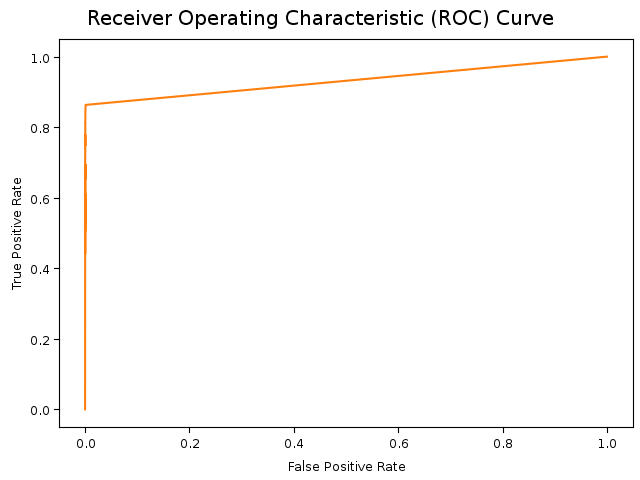

In [34]:
p.show()

<hr>
<b style = 'font-size:28px;font-family:Arial;color:#E37C4D'>10. Cleanup</b>

In [35]:
db_drop_table(table_name='glm_fraud_data')
db_drop_table(table_name='cc_glm')

True

In [36]:
remove_context()

True